Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем меньше батч сайз тем дольше нам нужно обучаться. Поскольку при маленьком батч-сайзе наш градиентный спуск не всегда происходит в верном направлении и градиент сходится дольше.

Посмотрим на какую-нибудь картинку:

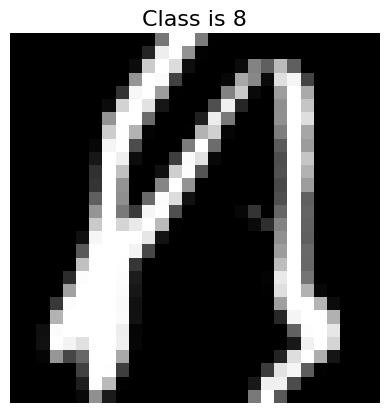

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [5]:
from torchvision.transforms import v2, ToPILImage
def plot_every_class_image():
    y = trainset.targets.unique()
    # Display results
    fig, axes = plt.subplots(2, 5, figsize=(8, 8))
    for ax, y_class in zip(axes.flatten(), y):
        # Plot the image
        ax.imshow(ToPILImage()(trainset.data[trainset.targets == y_class][0]))
        # Remove ticks and labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
        # Assign a title to the subplot based on the image's class
        ax.set_title(f'class: {y_class}')
    plt.show()
    # END Solution (do not delete this comment!)

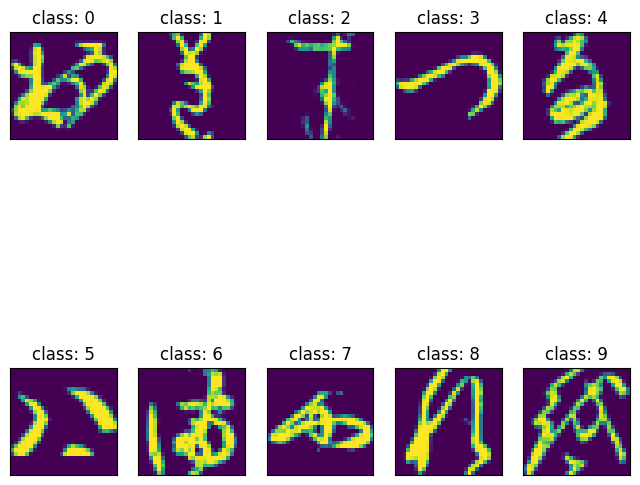

In [6]:
plot_every_class_image()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [119]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.layers(x)
        return logits

In [19]:
((28*28+1) * 256) + ((256+1) * 128) + ((128+1)*10)

235146

In [18]:
model=FCNet()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

235146


Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [20]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [35]:
# Создадим объект модели
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
fc_net = FCNet().to(DEVICE)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [36]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = fc_net(images)
    loss = loss_function(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9181
Epoch=2 loss=0.4557
Epoch=3 loss=0.3598
Epoch=4 loss=0.2987
Epoch=5 loss=0.2579
Epoch=6 loss=0.2234
Epoch=7 loss=0.1949
Epoch=8 loss=0.1723
Epoch=9 loss=0.1523
Epoch=10 loss=0.1355


In [41]:
get_accuracy(fc_net.to('cpu'), testloader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7baa11e49240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7baa11e49240>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

0.874

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [116]:
mean = trainset.data.float().mean(dim=(0,1,2)) / 255
std = trainset.data.float().std(dim=(0,1,2)) / 255
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

tensor(0.1918) tensor(0.3483)


In [120]:
fc_net = FCNet().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [121]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = fc_net(images)
    loss = loss_function(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6816
Epoch=2 loss=0.3018
Epoch=3 loss=0.2214
Epoch=4 loss=0.1727
Epoch=5 loss=0.1384
Epoch=6 loss=0.1111
Epoch=7 loss=0.0900
Epoch=8 loss=0.0736
Epoch=9 loss=0.0601
Epoch=10 loss=0.0498


In [122]:
get_accuracy(fc_net.to('cpu'), testloader)

0.8915

Как изменилась `accuracy` после нормализации?

Возросла с 0.874 до 0.8915

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [130]:
## YOUR CODE HERE
import torch.nn as nn

class FCNet_sigmoid(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 256),
            nn.Sigmoid(),
            nn.Linear(256,128),
            nn.Sigmoid(),
            nn.Linear(128,10)
        )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.layers(x)
        return logits

class FCNet_GELU(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 256),
            nn.GELU(),
            nn.Linear(256,128),
            nn.GELU(),
            nn.Linear(128,10)
        )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.layers(x)
        return logits


class FCNet_tanh(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,10)
        )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.layers(x)
        return logits

fc_net_sigmoid = FCNet_sigmoid().to(DEVICE)
fc_net_gelu = FCNet_GELU().to(DEVICE)
fc_net_tanh = FCNet_tanh().to(DEVICE)

def train(fc_net):
  fc_net = fc_net().to(DEVICE)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

  n_epochs = 10
  loss_history = []

  ## YOUR CODE HERE
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = fc_net(images)
      loss = loss_function(outputs, labels)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  return get_accuracy(fc_net.to('cpu'), testloader)

In [131]:
for model in [FCNet_sigmoid, FCNet_GELU, FCNet_tanh]:
  print(f'{model} accuracy: {train(model)}')

Epoch=1 loss=1.5380
Epoch=2 loss=0.7546
Epoch=3 loss=0.5481
Epoch=4 loss=0.4434
Epoch=5 loss=0.3719
Epoch=6 loss=0.3183
Epoch=7 loss=0.2760
Epoch=8 loss=0.2408
Epoch=9 loss=0.2117
Epoch=10 loss=0.1872
<class '__main__.FCNet_sigmoid'> accuracy: 0.8533
Epoch=1 loss=0.6604
Epoch=2 loss=0.2837
Epoch=3 loss=0.2054
Epoch=4 loss=0.1563
Epoch=5 loss=0.1230
Epoch=6 loss=0.0997
Epoch=7 loss=0.0795
Epoch=8 loss=0.0632
Epoch=9 loss=0.0502
Epoch=10 loss=0.0394
<class '__main__.FCNet_GELU'> accuracy: 0.8988
Epoch=1 loss=0.7725
Epoch=2 loss=0.3858
Epoch=3 loss=0.2592
Epoch=4 loss=0.1848
Epoch=5 loss=0.1378
Epoch=6 loss=0.1033
Epoch=7 loss=0.0780
Epoch=8 loss=0.0576
Epoch=9 loss=0.0436
Epoch=10 loss=0.0314
<class '__main__.FCNet_tanh'> accuracy: 0.9005


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

с сигмойдой метрика 0.8533

с gelu метрика 0.8988

с tanh метрика 0.9005

с tanh получилось получить лучший скор

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [141]:
def train(fc_net, optimizer_alg):
  fc_net = fc_net().to(DEVICE)
  loss_function = nn.CrossEntropyLoss()
  optimizer = optimizer_alg(fc_net.parameters(), lr=3e-4)

  n_epochs = 10
  loss_history = []

  ## YOUR CODE HERE
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = fc_net(images)
      loss = loss_function(outputs, labels)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
  return get_accuracy(fc_net.to('cpu'), testloader)

In [142]:
for optimizer_alg in [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.AdamW]:
  print(f'{optimizer_alg} accuracy: {train(FCNet_tanh, optimizer_alg)}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=0.7779
Epoch=2 loss=0.3845
Epoch=3 loss=0.2586
Epoch=4 loss=0.1853
Epoch=5 loss=0.1377
Epoch=6 loss=0.1033
Epoch=7 loss=0.0777
Epoch=8 loss=0.0576
Epoch=9 loss=0.0425
Epoch=10 loss=0.0313
<class 'torch.optim.adam.Adam'> accuracy: 0.9016
Epoch=1 loss=0.5679
Epoch=2 loss=0.3117
Epoch=3 loss=0.2171
Epoch=4 loss=0.1592
Epoch=5 loss=0.1198
Epoch=6 loss=0.0906
Epoch=7 loss=0.0680
Epoch=8 loss=0.0511
Epoch=9 loss=0.0377
Epoch=10 loss=0.0285
<class 'torch.optim.rmsprop.RMSprop'> accuracy: 0.8817
Epoch=1 loss=1.4058
Epoch=2 loss=1.0186
Epoch=3 loss=0.8907
Epoch=4 loss=0.8180
Epoch=5 loss=0.7698
Epoch=6 loss=0.7342
Epoch=7 loss=0.7070
Epoch=8 loss=0.6849
Epoch=9 loss=0.6668
Epoch=10 loss=0.6507
<class 'torch.optim.adagrad.Adagrad'> accuracy: 0.6822
Epoch=1 loss=0.7784
Epoch=2 loss=0.3879
Epoch=3 loss=0.2609
Epoch=4 loss=0.1862
Epoch=5 loss=0.1387
Epoch=6 loss=0.1033
Epoch=7 loss=0.0784
Epoch=8 loss=0.0583
Epoch=9 loss=0.0439
Epoch=10 loss=0.0327
<class 'torch.optim.adamw.AdamW'> acc

С Адамом получилась лучшая метрика 0.9016

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [138]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HER
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.where(x < 0, 0.0, x)
        return x


Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [140]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*28*28, 256),
            CustomReLU(),
            nn.Linear(256,128),
            CustomReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.layers(x)
        return logits

# Создадим объект модели
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
fc_net = FCNet().to(DEVICE)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = fc_net(images)
    loss = loss_function(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

get_accuracy(fc_net.to('cpu'), testloader)

Epoch=1 loss=0.6978
Epoch=2 loss=0.3122
Epoch=3 loss=0.2308
Epoch=4 loss=0.1799
Epoch=5 loss=0.1440
Epoch=6 loss=0.1174
Epoch=7 loss=0.0955
Epoch=8 loss=0.0785
Epoch=9 loss=0.0639
Epoch=10 loss=0.0526


0.8961

Действительно, CustomReLU работает как нужно

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.